## An Introduction to Model Selection
_Bryan Graham_
_University of California at Berkeley_  
_March 2025_
<br>
<br>
#### Code citation:
<br>
Graham, Bryan S. (2025). "An Introduction to Model Selection Python Jupyter Notebook," (Version 1.0) [Computer program]. Available at http://bryangraham.github.io/econometrics/ (Accessed 17 May 2025)
<br>
<br>

In [223]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import neighbors

In [63]:
# Directory where Nicargaruan calorie demand data file is location
data     =  '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/MaCSS/Data/'
graphics = '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/MaCSS/Graphics/'

We are interested in the relationship between total household outlay and calorie consumption. Understanding the nature of food demand in low income settings has important implications for understanding the prevalence of hunger and for food policy. The article by Shankar Subramanian and Angus Deaton. (1996). "The demand for food and calories," _Journal of Political Economy_ 104 (1): 133 - 162 provides a nice example of economics research in this area.

The dataset includes several years of data. We will work with X0 and Y0, which correspond to household outlay (in Cordobas) per adult equivalent and calorie consumption per adult equivalent respectively in the base year of of the survey (2000). 

In [64]:
# Read in Nicargaruan calorie demand data
red = pd.read_csv(data+'RPS_calorie_data.out') # Reading .csv as DataFrame
red[['X0','Y0']].describe()

,X0,Y0
count,1358.000000,1358.000000
mean,8.161556,7.491708
std,0.645467,0.602537
min,5.278722,3.644912
25%,7.726226,7.174405
50%,8.202351,7.565279
75%,8.619283,7.916748
max,10.316850,8.936883


This next block of code produces a histogram of calorie consumption. Many households in the sample are "hungry" by conventional definitions.

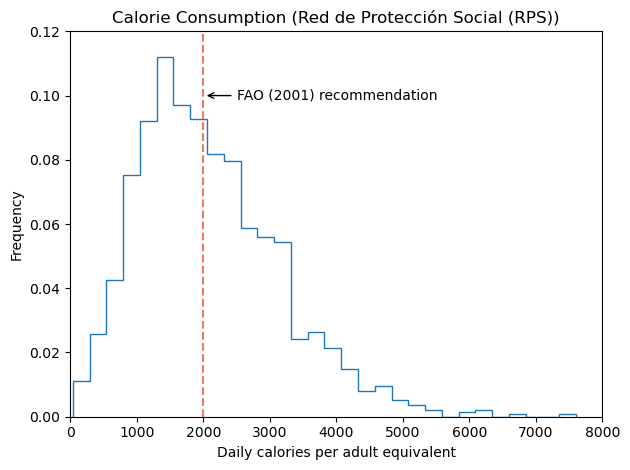

In [127]:
fig_calories, ax = plt.subplots()

n, bins, patches = ax.hist(np.exp(Y), bins = 30, density = False, histtype='step', align='mid', \
                           weights=np.ones_like(Y) / len(Y))

ax.plot((2000, 2000), (0, 0.12), color='#ED4E33', alpha = 0.75, linestyle='dashed')
ax.set_xlabel(r'Daily calories per adult equivalent')
ax.set_ylabel('Frequency')
ax.set_title('Calorie Consumption (Red de Protección Social (RPS))')
ax.annotate(r'FAO (2001) recommendation', \
            xy=(2010, 0.1), xytext=(2500, 0.1), \
            arrowprops=dict(arrowstyle="->"), \
            horizontalalignment='left',verticalalignment='center')

plt.ylim([0,0.12])
plt.xlim([0,8000])  

# Tweak spacing to prevent clipping of ylabel
fig_calories.tight_layout()
plt.show()

We can produce a similar histogram for our main predictor variable, household outlay, or expenditure, per adult equivalent. Expenditure is measure in 2001 Cordobas. The 2001 Cordoba-to-US-dollar exchange rate was $13.65$.

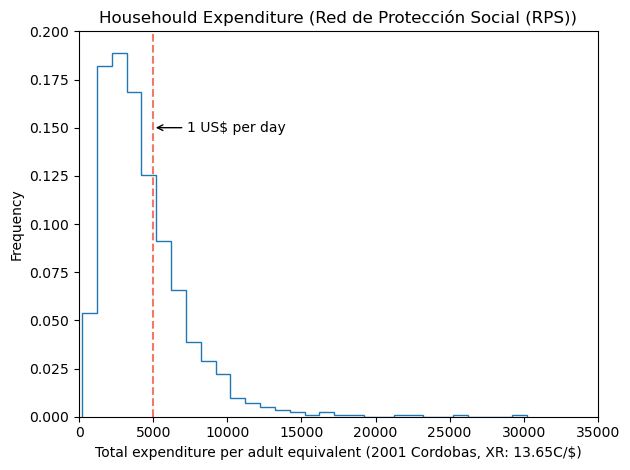

In [218]:
fig_expenditure, ax = plt.subplots()

n, bins, patches = ax.hist(np.exp(X), bins = 30, density = False, histtype='step', align='mid', \
                           weights=np.ones_like(X) / len(X))

ax.plot((365*13.65, 365*13.65), (0, 0.2), color='#ED4E33', alpha = 0.75, linestyle='dashed')
ax.set_xlabel(r'Total expenditure per adult equivalent (2001 Cordobas, XR: 13.65C/$)')
ax.set_ylabel('Frequency')
ax.set_title('Househould Expenditure (Red de Protección Social (RPS))')
ax.annotate(r'1 US$ per day', \
            xy=(365*13.65, 0.15), xytext=(365*20, 0.15), \
            arrowprops=dict(arrowstyle="->"), \
            horizontalalignment='left',verticalalignment='center')

plt.ylim([0,0.2])
plt.xlim([0,35000])  

# Tweak spacing to prevent clipping of ylabel
fig_expenditure.tight_layout()
plt.show()

Coefficients: 
 [0.68778462]


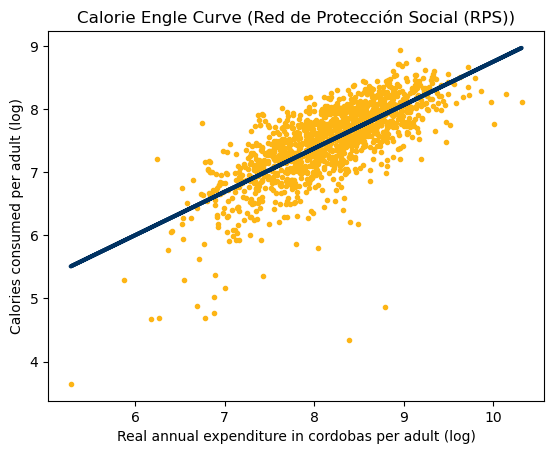

In [219]:
X = red['X0'].values.reshape(-1,1)
Y = red['Y0'].values

# Compute linear regression of total outlay onto calories
cdreg = LinearRegression().fit(X, Y)

# Compute fitted values
Y_hat = cdreg.predict(X)

# Print out the estimated regression coefficients
print("Coefficients: \n", cdreg.coef_)

# Plot fitted regression model
plt.scatter(X, Y, color="#FDB515", marker='.')
plt.plot(X, Y_hat, color="#003262", linewidth=3)

plt.title("Calorie Engle Curve (Red de Protección Social (RPS))")
plt.xlabel("Real annual expenditure in cordobas per adult (log)")
plt.ylabel("Calories consumed per adult (log)")


plt.show()

In [220]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, shuffle=False)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

cdreg = LinearRegression().fit(X_train, Y_train)
print(cdreg.score(X_train, Y_train))              # Training sample R-2
print(cdreg.score(X_test, Y_test))                # Test sample R-2

(679, 1) (679,)
(679, 1) (679,)
0.5398075604035906
0.5078714699906557


[Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5')]

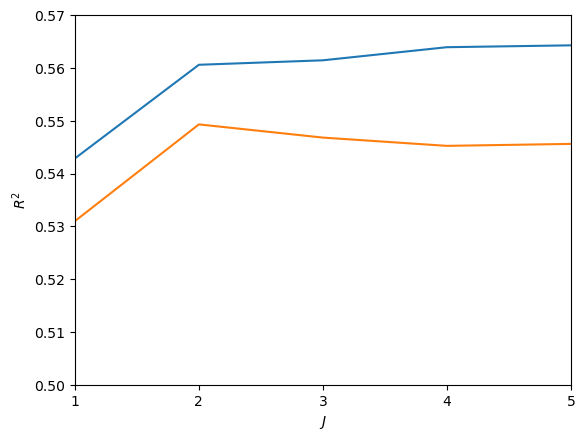

In [274]:
# Randomly split calorie data into two halves
i1, i2 = train_test_split(red['X0'], test_size=0.4, random_state=19)
i1     = i1.index.values     # First sample index values
i2     = i2.index.values     # Second sample index values

# Set of polynomial orders to consider
J_values   = [1, 2, 3, 4, 5]
risk_table = np.zeros((len(J_values),3))

# Create polynomial basis functions
poly = PolynomialFeatures(degree=len(J_values))
X_poly = poly.fit_transform(X)

m = 0                      
for J in J_values:

    polyregJ = LinearRegression().fit(X_poly[:,1:(J+1)], Y)
    R2       = polyregJ.score(X_poly[:,1:(J+1)], Y)
        
    polyregJ_train = LinearRegression().fit(X_poly[i1,1:(J+1)], Y[i1])
    R2_    = polyregJ_train.score(X_poly[i2,1:(J+1)], Y[i2])
            
    risk_table[m,:] = [J, R2, R2_]
    m += 1                  

fig = plt.figure()
ax = plt.axes()
ax.set_xlabel(r'$J$')
ax.set_ylabel(r"$R^2$")

ax.plot(risk_table[:,0], risk_table[:,1])
ax.plot(risk_table[:,0], risk_table[:,2])

plt.ylim([0.50,0.57])
plt.xlim([1,5])
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(['1', '2', '3', '4', '5'])

[Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5')]

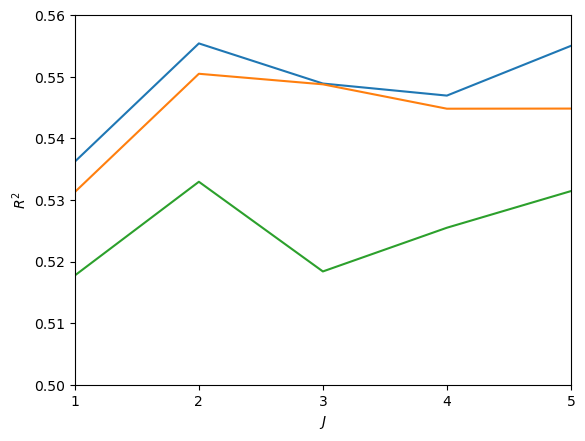

In [269]:
k_folds    = 3
risk_table = []

for J in J_values:
    polyregJ = LinearRegression().fit(X_poly[:,1:(J+1)], Y)
    risk_table.append([J] + cross_val_score(polyregJ, X_poly[:,1:(J+1)], Y, cv=k_folds).tolist())


risk_table = np.array(risk_table)    
fig = plt.figure()
ax = plt.axes()
ax.set_xlabel(r'$J$')
ax.set_ylabel(r"$R^2$")  
    
for k in range(1,k_folds+1):
    ax.plot(risk_table[:,0], risk_table[:,k])
    
    
plt.ylim([0.50,0.56])
plt.xlim([1,5])
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(['1', '2', '3', '4', '5'])    

[Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5')]

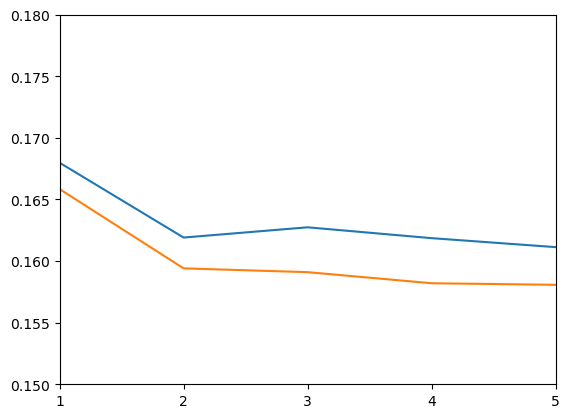

In [271]:
risk_table = np.zeros((len(J_values),3))

m = 0                      
for J in J_values:

    polyregJ = LinearRegression().fit(X_poly[:,1:(J+1)], Y)
    Y_hatJ   = polyregJ.predict(X_poly[:,1:(J+1)])
    s2       = ((Y - Y_hatJ)**2).mean()
    Y_hat_cv = cross_val_predict(polyregJ, X_poly[:,1:(J+1)], Y, cv=5)
    cv_MSE   = ((Y - Y_hat_cv)**2).mean()
    
    risk_table[m,:] = [J, cv_MSE, s2]
    m += 1                  

fig = plt.figure()
ax = plt.axes()
ax.plot(risk_table[:,0], risk_table[:,1])
ax.plot(risk_table[:,0], risk_table[:,2])

plt.ylim([0.15,0.18])
plt.xlim([1,5])
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(['1', '2', '3', '4', '5'])  

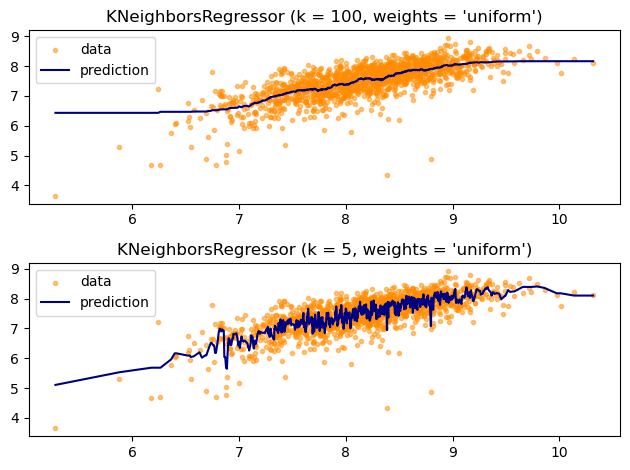

In [251]:
for i, K in enumerate([100, 5]):
    knn = neighbors.KNeighborsRegressor(K, weights='uniform')
    Y_ = knn.fit(X, Y).predict(X)

    plt.subplot(2, 1, i + 1)
    plt.scatter(X, Y, color="darkorange", label="data", marker='.', alpha = 0.5)
    
    Xs, Y_s = zip(*sorted(zip(X, Y_)))
    
    plt.plot(Xs, Y_s, color="navy", label="prediction")
    plt.axis("tight")
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i, weights = 'uniform')" % (K))

plt.tight_layout()
plt.show()

In [19]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.data.shape, housing.target.shape)
print(housing.target_names)
print(housing.feature_names)

(20640, 8) (20640,)
['MedHouseVal']
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [29]:
Y = housing.target
X = housing.data[:,6:8]

# Create Grid for Prediction
x_range = np.linspace(x[:, 0].min(), x[:, 0].max(), 30)
y_range = np.linspace(x[:, 1].min(), x[:, 1].max(), 30)
X, Y = np.meshgrid(x_range, y_range)

# Predict on Grid
Z = model.predict(np.c_[X.ravel(), Y.ravel()]).reshape(X.shape)

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8) # Regression surface
ax.scatter(x[:, 0], x[:, 1], y, color='r', marker='o', label='Data Points') # Data points
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Target Variable')
ax.set_title('Spatial Regression Surface Plot')
ax.legend()
plt.show()